In [1]:
import sys
sys.path.insert(0, 'C:\\Users\\Z478SG\\Desktop\\Ecole\\OpenClassrooms-Projet-7\\modeling\\')

In [2]:
import matplotlib.pyplot as plt
import mlflow
from mlflow.models import infer_signature
import pandas as pd
import seaborn as sns
import pipelines
import gc

from lightgbm import LGBMClassifier
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold

from pipelines.utils.helpers import display_importances

# Reaload libs
import importlib
importlib.reload(sys.modules['pipelines'])

<module 'pipelines' (namespace) from ['C:\\Users\\Z478SG\\Desktop\\Ecole\\OpenClassrooms-Projet-7\\modeling\\pipelines']>

In [3]:
mlflow.set_tracking_uri(uri="file:///C:/Users/Z478SG/Desktop/Ecole/OpenClassrooms-Projet-7/modeling/mlruns")
mlflow.set_experiment("Credit_Scoring_Model")

<Experiment: artifact_location='file:///C:/Users/Z478SG/Desktop/Ecole/OpenClassrooms-Projet-7/modeling/mlruns/534552444611581124', creation_time=1725124865324, experiment_id='534552444611581124', last_update_time=1725124865324, lifecycle_stage='active', name='Credit_Scoring_Model', tags={}>

In [4]:
df = pd.read_csv('../data/04_feature/second_features_selection.csv')

In [5]:
df = df.astype('float16')

# Feature importance sur toutes les features avec LightGBM

In [6]:
def get_feature_importance(df, params, num_folds=5, stratified=True):
    X = df.drop(columns=['TARGET'])
    y = df['TARGET']

    if stratified:
        # used for stratified cross validation (i.e. each fold has the same proportion of target variable as the entire dataset)
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        # used to split the data into training and validation sets while evaluating a model (i.e. cross-validation) 
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(df.shape[0])
    feature_importance_df = pd.DataFrame()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
        train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]

        clf = LGBMClassifier(**params)
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc')
        
        # OOF stands for Out-Of-Fold predictions. In K-Fold Cross-Validation, oof_preds are the predictions made on the validation folds. For each fold, the model is trained on the training folds and makes predictions on the validation fold. These predictions are collected and combined to form the oof_preds. They provide an estimate of the model's performance on unseen data
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train_x.columns
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1

        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        feature_importance_df = feature_importance_df.groupby('feature').mean().reset_index()
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
    
    roc_auc_score_ = roc_auc_score(y, oof_preds)
    print('Full AUC score %.6f' % roc_auc_score_)

    return feature_importance_df, roc_auc_score_

In [7]:
params = {
    # 'nthread': 4,
    'n_estimators': 100,
    'learning_rate': 0.01,
    'num_leaves': 31,
    # 'colsample_bytree': 0.9497036,
    # 'subsample': 0.8715623,
    # 'max_depth': 8,
    # 'reg_alpha': 0.041545473,
    # 'reg_lambda': 0.0735294,
    # 'min_split_gain': 0.0222415,
    # 'min_child_weight': 39.3259775,
    # 'silent': -1,
    "scale_pos_weight": 11.334168964652795,
}

In [8]:
stratified = True
num_folds = 5

# Feature importance sur toutes les featuers

In [ ]:
with mlflow.start_run():
    mlflow.set_tag("LGBM Feature importance", "first features")

    feature_importance_df, roc_auc_score_ = get_feature_importance(df, params, num_folds, stratified)

    mlflow.log_metric("AUC", roc_auc_score_)
    
    for feature in feature_importance_df['feature']:
        mlflow.log_param(feature, feature_importance_df['importance'])

In [ ]:
display_importances(feature_importance_df)

On sélectionne 20 features qu'on va essayer de réduire à 10 avec les corrélations

In [ ]:
feature_importance_df.to_csv('../data/08_reporting/feature_importance.csv', index=False)

AUC moyen de 0.78 --> Le modèle tombe en moyenne 78% de fois sur la bonne réponse (>0.5 donc mieux qu'aléatoire)



Les 15 features qui semblent avoir le plus d'importances sont :
['PAYMENT_RATE', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'ANNUITY_INCOME_PERC', 'INSTAL_DBD_MEAN', 'AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE', 'REGION_POPULATION_RELATIVE', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN']

In [8]:
first_features_df = df[['TARGET', 'PAYMENT_RATE', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'ANNUITY_INCOME_PERC', 'INSTAL_DBD_MEAN', 'AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE', 'REGION_POPULATION_RELATIVE', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN']]

## Matrice de corrélation sur le top 15 des features importantes

In [9]:
correlation_matrix = first_features_df.select_dtypes(exclude='object').corr()

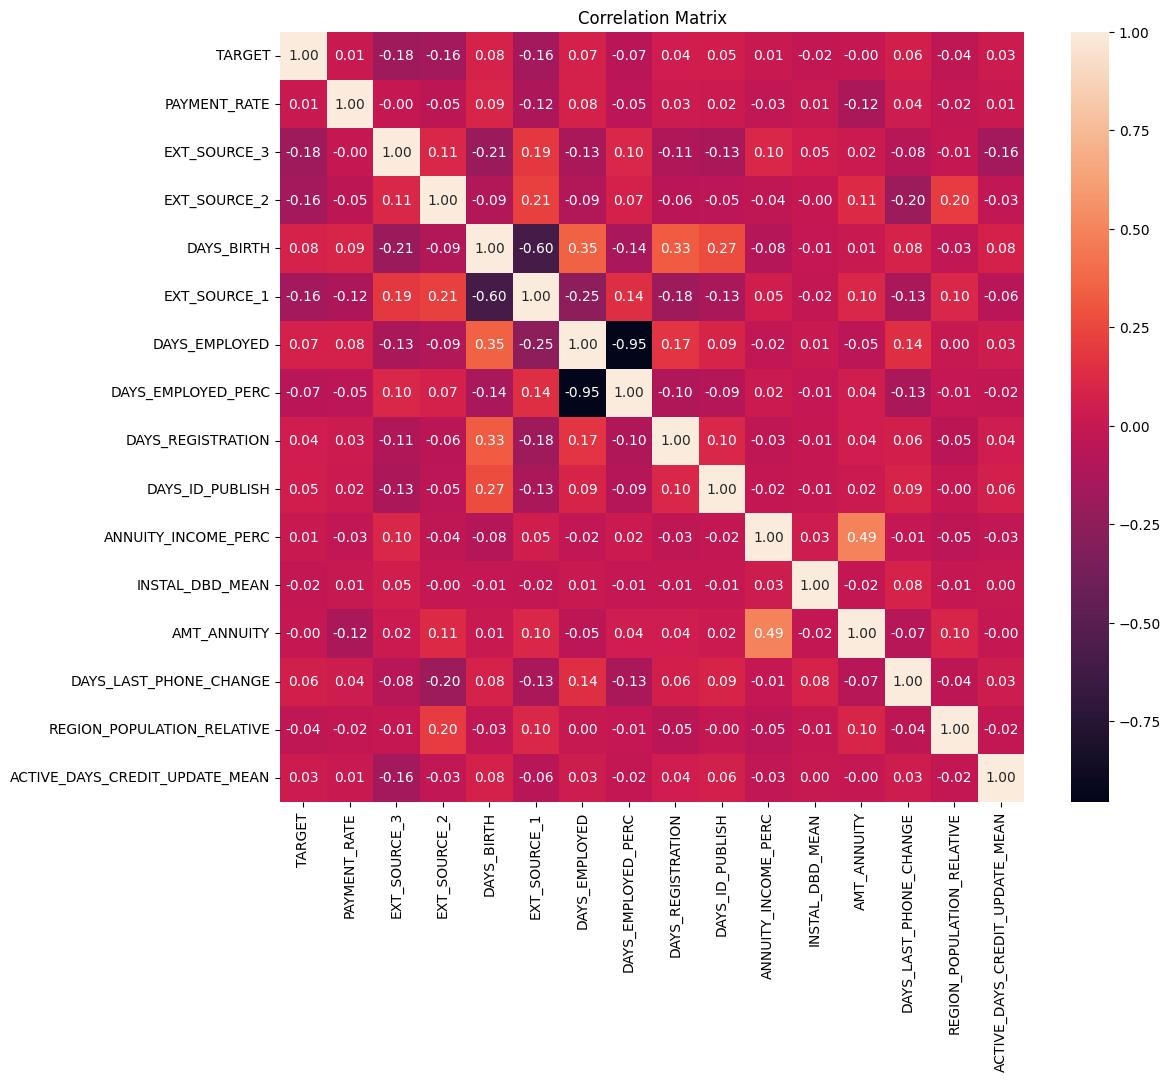

In [10]:
# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

On supprime :
- DAYS_EMPLOYED car quasi parfaitement correlé à DAYS_EMPLOYED_PERC et bien plus correlé à EXT_SOURCE_2 alors qu'autant à TARGET
- AMT_ANNUITY car très correlé à ANNUITY_INCOME_PERC et moins important
- DAYS_ID_PUBLISH et DAYS_REGISTRATION car bien correlées à DAYS_BIRTH et moins important

Les EXT_SOURCE_x sont bien correlées mais trop importantes pour être supprimées

In [9]:
second_features_df = df[['TARGET', 'PAYMENT_RATE', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'DAYS_EMPLOYED_PERC', 'ANNUITY_INCOME_PERC', 'INSTAL_DBD_MEAN', 'DAYS_LAST_PHONE_CHANGE', 'REGION_POPULATION_RELATIVE', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN']]

## Feature importance sur les 11 featurse restantes

In [12]:
with mlflow.start_run():
    mlflow.set_tag("LGBM Feature importance", "second features")

    feature_importance_df, roc_auc_score_ = get_feature_importance(second_features_df, params, num_folds, stratified)

    mlflow.log_metric("AUC", roc_auc_score_)
    
    for feature in feature_importance_df['feature']:
        mlflow.log_param(feature, feature_importance_df['importance'])

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2629
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 11
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

KeyboardInterrupt: 

Feature Selection Strategy:

Threshold-based selection: Choose features above a certain importance threshold. From your graph, features like PAYMENT_RATE, EXT_SOURCE_3, EXT_SOURCE_2, DAYS_BIRTH, and EXT_SOURCE_1 stand out as highly important.  
Top N features: Select the top N most important features. You could start with the top 10-15 features and gradually increase or decrease based on model performance.  
Cumulative importance: Select features that cumulatively account for a certain percentage (e.g., 80% or 90%) of total importance.  
Domain knowledge: Combine the importance scores with domain expertise about which features are most relevant to credit risk assessment.  

# Feature importance (after hyperparameters selection)

In [4]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split

In [2]:
data_path = "C:\\Users\\Z478SG\\Desktop\\Ecole\\OpenClassrooms-Projet-7\\modeling\\data\\04_feature\\second_features_selection.csv"

test_size = 0.2
random_state = 18

In [5]:
raw_data = pd.read_csv(data_path)
data = raw_data.astype('float16')

X = data.drop("TARGET", axis=1)
y = data["TARGET"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [6]:
with open('C:\\Users\\Z478SG\\Desktop\\Ecole\\OpenClassrooms-Projet-7\\modeling\\data\\06_models\\model.pkl', 'rb') as f:
    best_model = pickle.load(f)

C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


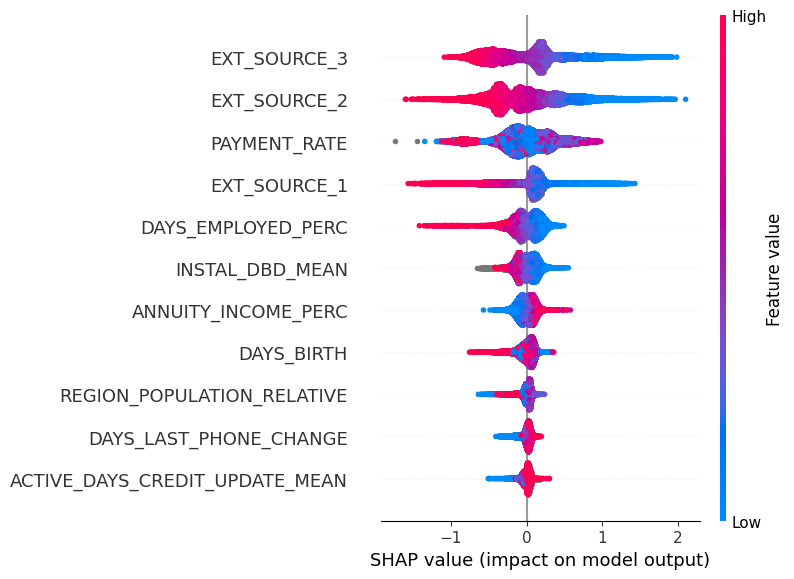

In [9]:
import shap

def analyze_feature_importance(model, X):
    # Importance globale des features
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Résumé de l'importance globale
    shap.summary_plot(shap_values, X)
    
    # Importance locale pour un exemple spécifique
    shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

# Utilisation
analyze_feature_importance(best_model, X_test)

Ce graphique représente l'importance des features (caractéristiques) dans un modèle prédictif, utilisant la méthode SHAP (SHapley Additive exPlanations). Voici comment l'interpréter :

1. Ordre des features : Les features sont classées de haut en bas par ordre d'importance décroissante. Ainsi, EXT_SOURCE_3 a le plus grand impact global sur les prédictions du modèle, suivi de EXT_SOURCE_2, etc.

2. Impact sur le modèle : L'axe horizontal montre l'impact de chaque feature sur la prédiction du modèle. Les valeurs à droite de 0 indiquent un impact positif (augmentant la prédiction), tandis que les valeurs à gauche indiquent un impact négatif (diminuant la prédiction).

3. Distribution des valeurs : Chaque ligne horizontale représente la distribution des valeurs SHAP pour cette feature à travers tous les échantillons.

4. Couleur : La couleur indique la valeur de la feature elle-même, du bleu (valeur basse) au rouge (valeur élevée).

Interprétations spécifiques :

- EXT_SOURCE_3, EXT_SOURCE_2 et EXT_SOURCE_1 ont les impacts les plus importants et variés. Des valeurs élevées (en rouge) pour ces features tendent à avoir un impact négatif sur la prédiction, tandis que des valeurs basses (en bleu) ont un impact positif.

- PAYMENT_RATE montre une distribution intéressante : des valeurs très basses ou très élevées ont tendance à avoir un impact positif, tandis que les valeurs moyennes ont un impact négatif.

- DAYS_EMPLOYED_PERC et INSTAL_DBD_MEAN ont des effets plus modérés mais toujours significatifs.

- Les features en bas du graphique, comme ACTIVE_DAYS_CREDIT_UPDATE_MEAN, ont un impact global plus faible sur les prédictions du modèle.

Ce type de visualisation est très utile pour comprendre comment le modèle utilise différentes informations pour faire ses prédictions et peut aider à identifier les features les plus importantes pour le problème en question.